# Tutorial #1 :: Pre-processing Inertial Data
We begin by reading our inertial data data, visualizing it, and performing very simple pre-processing in order to clean it up and ready it for subsequent estimation techniques. 

To begin, let's import some data that we'll be using for the remainder of these lessons. Some nice inertial data with corresponding ground truth can be obtained from the "High Precision Reference Data Set for Pedestrian Navigation using Foot-Mounted Inertial Sensors," : http://www.dlr.de/kn/desktopdefault.aspx/tabid-8498/14560_read-36505/  

These tutorials will assume you have a folder named "data" in the top-most repository level (i.e. one level above these notebooks). The IMU data should be renamed (e.g. from "IMURaw.txt") to "imudata.txt," and the ground truth data should be renamed (e.g. from "Synchronized1stWalk_rectangle_020810_15_39") to "groundtruth.txt." We will be using the very first data set from those listed on the website above: "Walk 2D - rectangle."

## Loading the Inertial and Ground Truth Data
Let's begin my loading the inertial data. The data of interest in this file are:

[col3: timestamp] [col4-6: accx/y/z] [col7-9: gyrox/y/z] [col10-12: magx/y/z] [heading]


In [7]:
import numpy as np
data_imu = np.array(np.loadtxt('../data/imudata.txt', skiprows=1))

Let's have a quick look at the raw sensor data --- we have 3 axes each of accelerometer, gyroscope, and magnetometer data.

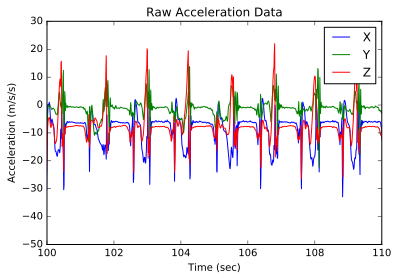

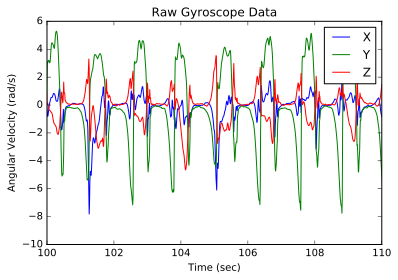

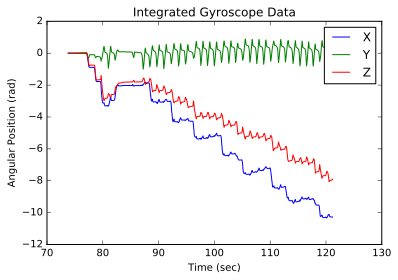

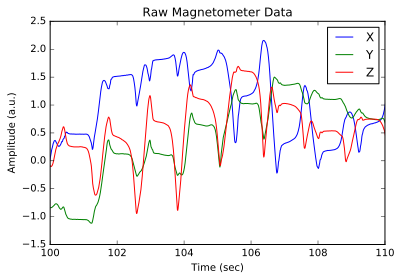

In [25]:
import matplotlib
import matplotlib.pyplot as plt

# first, some Jupyter plotting config
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# Plot ACCELEROMETER
tstamps = data_imu[:,2]
acc_xyz = data_imu[:,3:6]
plt.plot(tstamps, acc_xyz)
plt.title('Raw Acceleration Data')
plt.xlabel('Time (sec)')
plt.ylabel('Acceleration (m/s/s)')
plt.legend(['X','Y','Z'])
plt.xlim([100, 110])
plt.show()

# Plot GYROSCOPE
gyr_xyz = data_imu[:,6:9]
plt.plot(tstamps, gyr_xyz)
plt.title('Raw Gyroscope Data')
plt.xlabel('Time (sec)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend(['X','Y','Z'])
plt.xlim([100, 110])
plt.show()

# Plot integrated GYROSCOPE
plt.plot(tstamps, (1.0/100)*np.cumsum(gyr_xyz, axis=0))
plt.title('Integrated Gyroscope Data')
plt.xlabel('Time (sec)')
plt.ylabel('Angular Position (rad)')
plt.legend(['X','Y','Z'])
#plt.xlim([100, 110])
plt.show()

# Plot MAGNETOMETER
mag_xyz = data_imu[:,9:12]
plt.plot(tstamps, mag_xyz)
plt.title('Raw Magnetometer Data')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (a.u.)')
plt.legend(['X','Y','Z'])
plt.xlim([100, 110])
plt.show()

For filtering, we may also care about the sampling rate of the inertial data. This can be estimated by looking at the average of time between measurements like so:

In [3]:
sample_rate = 1.0/np.mean(np.diff(tstamps))
print( 'Sample Rate:', np.round(sample_rate,2), 'Hz')

Sample Rate: 98.94 Hz


Note that the accelerometer signal has a DC (constant) offset over short periods. This is due to the gravity component of acceleration. For mobile phone development this is often split into two components: linear acceleration, in which the gravity component has been removed, and the gravity component itself. This can be done easily by filtering the accelerometer signals.

For filtering, we will use what's called a Butterworth low-pass filter. Low-pass meaning we will not attenuate (pass) signals below (low) some cutoff frequency. This will give us our gravity component. A Butterworth filter has a maximally flat frequency response in the pass band, meaning there will be very little attenuation or distortion of the frequencies we are not trying to reject. Subtracting the gravity component will give us the linear acceleration.

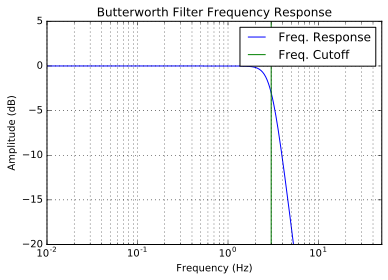

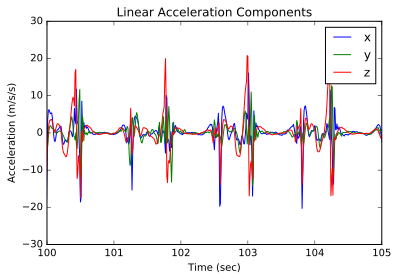

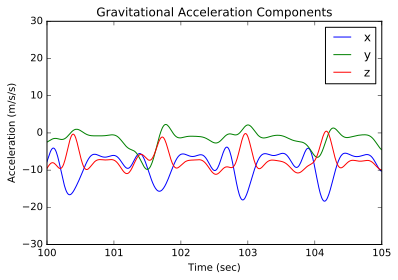

In [4]:
from scipy import signal

filt_order = 4;
filt_type = 'lowpass'
filt_freq = 3
nyquist = sample_rate/2.0;

# Create and plot the filter
b, a = signal.butter(N=filt_order, Wn=filt_freq/nyquist, btype=filt_type, analog=False, output='ba')
w, h = signal.freqz(b, a)
plt.plot(w/np.pi*nyquist, 20*np.log10(abs(h)))
plt.axvline(filt_freq, color='green')
plt.xscale('log')
plt.title('Butterworth Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(which='both', axis='both')
plt.ylim([-20,5])
plt.xlim([1e-2, 5e1])
plt.legend(['Freq. Response', 'Freq. Cutoff'])
plt.show()

# Filter the data
grav_xyz = signal.filtfilt(b,a,acc_xyz, axis=0)
lin_xyz = acc_xyz - grav_xyz

# Plot linear acceleration
plt.plot(tstamps, lin_xyz)
plt.title('Linear Acceleration Components')
plt.xlabel('Time (sec)')
plt.ylabel('Acceleration (m/s/s)')
plt.xlim([100,105])
plt.ylim([-30, 30])
plt.legend(['x','y','z'])
plt.show()

# Plot gravity vector
plt.plot(tstamps, grav_xyz)
plt.title('Gravitational Acceleration Components')
plt.xlabel('Time (sec)')
plt.ylabel('Acceleration (m/s/s)')
plt.xlim([100,105])
plt.ylim([-30, 30])
plt.legend(['x','y','z'])
plt.show()

We may also have to pre-process the gyroscope and magnetometer data, but for now we'll leave them as is. In general, gyroscope data is much cleaner than accelerometer data, but magnetometers often have spikes from ferrous metal objects that come in and out of proximity to the sensor. 

## Loading the Ground Truth Data
Next we load the ground truth data from the Vicon motion capture system. The data of interest in this file are:

timestampLocal timestampVicon translation[3] rotation[9]

[col1: synchronized seq. #] [col3-5: xyz] [col6-14: rotation ??] 

In [5]:
data_tru = np.array(np.loadtxt('../data/groundtruth.txt', skiprows=1))
tru_xyz = data_tru[:,[2,3,4]]/1000.0
tru_rpy = data_tru[:,[5,6,7]]

And now to visualize the ground truth data

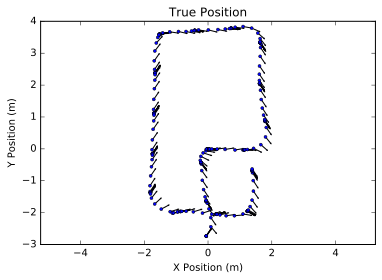

In [6]:
STOP = 3000
STEP = 10
xdata = tru_xyz[0:STOP:STEP,0]
ydata = tru_xyz[0:STOP:STEP,1]
zdata = tru_xyz[0:STOP:STEP,2]
yaws = tru_rpy[0:STOP:STEP,1]

# Plot true x/y positions (ignore vertical)
plt.plot(xdata, ydata, 'ob', markersize=3)
# Add directional arrows
for i in range(len(xdata)):
    x = xdata[i]
    y = ydata[i]
    dx = 0.25*np.cos(yaws[i])
    dy = 0.25*np.sin(yaws[i])
    plt.arrow( x, y, dx, dy )
        
plt.title('True Position')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.show()

And that's it! We know what kind of data we have, we've pre-processed it, and we know what the true position looks like. Now we need to explore different types of state estimation techniques that will allow us to estimate the position for a given time. 